# Actor-Critic cartpole 
---

CartPole 문제개요

- 기둥을 달고있는 카트를 좌우로 움직여서 기둥의 균형을 잡는 문제
- 기둥이 무너지거나 카트가 화면 밖으로 나가면 게임은 끝
- 기둥을 오래 붙들고 있을수록 보상증가

![poster](https://user-images.githubusercontent.com/40904225/148472832-80338484-2dea-4d08-927b-46ccccfa8e20.jpg)

In [63]:
import gym
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import deque
import copy
import random

In [64]:
env = gym.make('CartPole-v1')
env._max_episode_steps=1000
print(env._max_episode_steps)

1000


In [65]:
help(env.unwrapped)

Help on CartPoleEnv in module gym.envs.classic_control.cartpole object:

class CartPoleEnv(gym.core.Env)
 |  Description:
 |      A pole is attached by an un-actuated joint to a cart, which moves along
 |      a frictionless track. The pendulum starts upright, and the goal is to
 |      prevent it from falling over by increasing and reducing the cart's
 |      velocity.
 |  
 |  Source:
 |      This environment corresponds to the version of the cart-pole problem
 |      described by Barto, Sutton, and Anderson
 |  
 |  Observation:
 |      Type: Box(4)
 |      Num     Observation               Min                     Max
 |      0       Cart Position             -4.8                    4.8
 |      1       Cart Velocity             -Inf                    Inf
 |      2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
 |      3       Pole Angular Velocity     -Inf                    Inf
 |  
 |  Actions:
 |      Type: Discrete(2)
 |      Num   Action
 |      0  

In [66]:
s = env.reset()
n_state = s.shape[0]
n_action = env.action_space.n
print('State dimension',n_state)
print('Number of action option',n_action)

State dimension 4
Number of action option 2


In [67]:
# 아직 이 블럭코드는 실행하면 안됨! 구조만 짜놓기
def play_or_train_agent(env,agent,eps,train=True):
    '''
    목표: agent를 환경에 맞게 train할것인지 단순 play할것인지 구성
    입력인자
        env: environment(CartPole)
        agent: agnet
        eps: epsilon-greedy (초기: 1, 최종: 0.1밑으론 하락x)
        train: 학습여부(True: 학습, False: play)
    출력인자
        total_reward: 
        loss: 모니터링을 위한 TD error의 추이
    '''
    s = env.reset()
    total_reward = 0
    
    for t in range(env._max_episode_steps):
        #<! s로 부터 action추출>
        
        next_s,reward,done,_ = env.step(action)
        total_reward += reward
        
        if train:
            #<! TD loss계산 및 업데이트>
                
        s = next_s        
        if done:
            break
    return total_reward, loss

IndentationError: expected an indented block (<ipython-input-67-21ee323089b8>, line 26)

In [68]:
# 모델 만들기
# Hidden layer는 sigmoid, tanh를 금기 -> limitation을 걸 여지가 있음
# 마지막 layer에서는 policy, value에 맞도록 Activation 고려 필
class NN_model(nn.Module):
    def __init__(self,input_dim=n_state,output_dim=n_action):
        super(NN_model,self).__init__()
        '''
        입력변수
            input_dim: state의 차원 -> cartpole [위치, 속도, 각도, 각속도]
            output_dim: action의 차원 -> cartpole [왼쪽, 오른쪽]
                        critic의 차원 -> 1
        N.N 구조
            4 layer구조 (2 hidden layer).
            hidden node개수는 64개로 통일.
            activation function은 Relu 설정
        '''
        self.lin1 = nn.Linear(input_dim,64)
        self.lin2 = nn.Linear(64,64)
        self.policy_out = nn.Linear(64,output_dim)
        self.value_out = nn.Linear(64,1)
        
    def forward(self,x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        policy = self.policy_out(x)
        value = self.value_out(x).squeeze(dim=-1)
        return policy, value
    
    def get_action(self,x):
        x = torch.FloatTensor(x[None])
        policy,_ = self.forward(x)
        policy = F.softmax(policy,dim=-1)
        actions = np.array([np.random.choice(len(p), p=p) 
                            for p in policy.detach().cpu().numpy()])
        return actions
    
agent = NN_model()
optimizer = optim.Adam(agent.parameters(),lr=1e-03)

In [69]:
def A2C_loss(state,action,reward,next_state,done,gamma=0.99,agent=agent):
    '''
    목적: A2C loss계산후 agent 학습
        목적함수: -log(policy)*value + (value_infer-value_target)**2 + policy*log(policy)
            "-log(policy)*value": Actor-loss(exploitation)
            "policy*log(policy)": Actor-entropy(exploration)
            "(value_infer-value_target)**2": Critic-loss
    입력인자
        state: 상태
        action: 액션
        reward: 보상
        next_state: 다음상태
        done: 종료여부
        gamma: discount factor(할인율)
        agent: agent
    출력인자
        total_loss: 모니터링을 위한 total_loss
    '''
    state = torch.FloatTensor(state)
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    next_state = torch.FloatTensor(next_state)
    done = torch.tensor(done,dtype=torch.uint8)
    
    policy, value = agent(state)
    next_policy, next_value = agent(next_state)

    probs = F.softmax(policy,dim=-1)
    logprobs = F.log_softmax(policy,dim=-1)
    next_value[done] = 0.
    
    target_value = reward + gamma*next_value
    advantage = target_value-value
    
    logp_actions = logprobs[np.arange(state.shape[0]),action]
    
    entropy = -probs*logprobs
    
    actor_loss = -(logp_actions*advantage.detach()).mean() - 0.001*entropy.mean()
    critic_loss = F.mse_loss(target_value.detach(),value)
    total_loss = actor_loss + critic_loss
    
    return total_loss

In [70]:
# 이제 코드 블럭을 완성합시다
def play_or_train_agent(env,agent,optimizer,train=False):
    '''
    목표: agent를 환경에 맞게 train할것인지 단순 play할것인지 구성
    입력인자
        env: environment(CartPole)
        agent: agnet
        optimizer: optimizer
        train: 학습여부(True: 학습, False: play)
    출력인자
        total_reward:  최종보상
        loss: 모니터링을 위한 TD error의 추이
    '''
    total_reward = 0
    s = env.reset()

    while True:
        action = agent.get_action(s)[0]

        new_s, reward, done, _ = env.step(action)
        total_reward += reward
        
        if train:
            optimizer.zero_grad()
            loss = A2C_loss([s],[action],[reward],[new_s],[done],agent=agent)
            loss.backward()
            optimizer.step()
        
        s = new_s
        if done:
            break
    if train:
        return total_reward, loss.item()
    else:
        return None

Episode 62


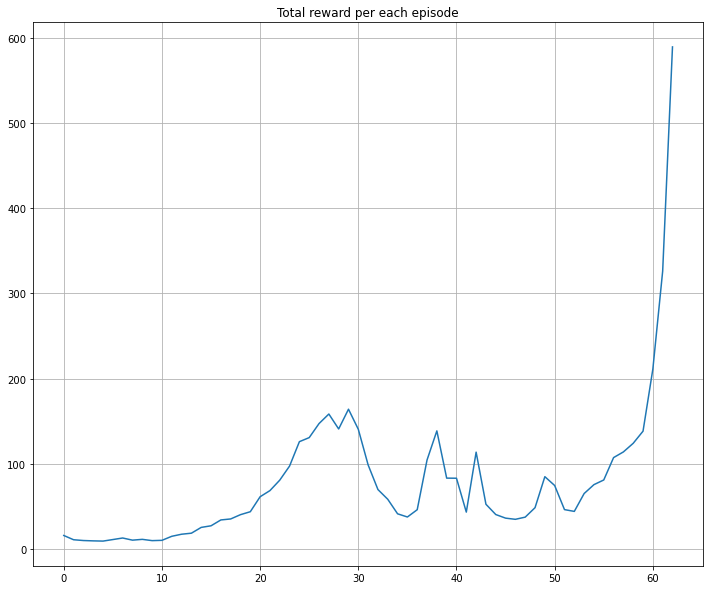

 62%|██████▏   | 62/100 [04:47<02:56,  4.64s/it]

Agent finds solution! Final score : 589.1


In [72]:
# 주 학습 - 에피소드마다 reward, td_loss값의 추이를 지켜봅시다
from tqdm import trange
from IPython.display import clear_output

agent = NN_model()
optimizer = optim.Adam(agent.parameters(),lr=1e-04)

episode_rewards = []
max_episodes = 100
mini_sessions = 50

for episode in trange(max_episodes):
    mini_reward = []
    for mini_session in range(mini_sessions):
        episode_reward, total_loss = play_or_train_agent(env,agent=agent,optimizer=optimizer,train=True)
        mini_reward.append(episode_reward)
    
    episode_rewards.append(np.mean(mini_reward))
    A2C_losses.append(np.mean(mini_td))
    
    clear_output(True)
    print("Episode",episode)
    
    plt.figure(figsize=[12, 10])
    plt.title("Total reward per each episode")
    plt.plot(episode_rewards)
    plt.grid()
    plt.show()
    
    if np.mean(mini_reward) >= 500:
        print(f"Agent finds solution! Final score : {np.mean(mini_reward)}")
        break

In [73]:
torch.save(agent,'./A2C_cartpole.pth')

In [75]:
# 플레이 해봅시다!
# 플레이 화면이 출력될것입니다. 만약 안되면 ./videos 폴더의 비디오 파일로 저장되어있는것을 확인!
import gym.wrappers

agent = torch.load('./A2C_cartpole.pth')
with gym.wrappers.Monitor(gym.make("CartPole-v1"), directory="videos", force=True) as env_monitor:
    play_or_train_agent(env_monitor,agent=agent,optimizer=optimizer,train=False)

In [76]:
from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices